## Multi-fidelity Bayesian optimization (MFBO) of COFs for Xe/Kr separations.
1. We have a set of COFs from a database. Each COF is characterized by a feature vector $$x \in \mathcal{X} \subset R^d$$ were d=14.

2. We have **two different types** of simulations to calculate **the same material property**, the adsorptive Xe/Kr selectivity $S_{Xe/Kr}$. However, we only have a single objective: to maximize the high-fidelity selectivity. 
$$\arg\max_{x \in \mathcal{X}}[S^{(\ell=\text{high})}_{Xe/Kr}(x)]$$

3. Multi-Fidelity options: 
    1. low-fidelity  => Henry coefficient calculation - MC integration: $S_{Xe/Kr}^{\text{low}} = \frac{H_{Xe}}{H_{Kr}}$
    2. high-fidelity => GCMC mixture simulation - 80:20 (Kr:Xe) at 298 K and 1.0 bar: $S_{Xe/Kr}^{\text{high}} = \frac{n_{Xe} / n_{Kr}}{y_{Xe}/y_{Kr}}$


3. We will initialize the surrogate model with a few (3) COFs with simulations under **both** fidelities.
    1. The fist COF will be the one closest to the center of the normalized feature space
    2. The rest will be chosen to maximize diversity of the training set


4. Model:
    1. Botorch GP surrogate model: [SingleTaskMultiFidelityGP](https://botorch.org/api/models.html#module-botorch.models.gp_regression_fidelity) or [FixedNoiseMultiFidelityGP](https://botorch.org/api/models.html#botorch.models.gp_regression_fidelity.FixedNoiseMultiFidelityGP)
        - Needed to use [this](https://botorch.org/api/optim.html#module-botorch.optim.fit) optimizer to correct matrix jitter
    2. We  use the augmented-EI (aEI) acquisition function from [here](https://link.springer.com/content/pdf/10.1007/s00158-005-0587-0.pdf)


-  Helpful [tutorial](https://botorch.org/tutorials/discrete_multi_fidelity_bo) for a similar BoTorch Model used

In [1]:
import torch
import gpytorch

from botorch.models import SingleTaskMultiFidelityGP
from botorch.acquisition.analytic import ExpectedImprovement

from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch import fit_gpytorch_model
from sklearn.ensemble import RandomForestRegressor

from scipy.stats import norm
import numpy as np
import pickle
import h5py # for .jld2 files
import os
import time

import matplotlib.pyplot as plt

from sklearn.metrics import r2_score, mean_absolute_error

/Users/cokes/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
###
#  figure settings 
###
import seaborn as sns
sns.set(style='ticks', palette='Set2', font_scale=1.5, rc={"lines.linewidth": 3})
sns.despine()
# plt.rcParams.update({'font.size': 16})
# plt.rcParams['figure.dpi'] = 1200 # 600-1200 for paper quality

save_figures = True

<Figure size 640x480 with 0 Axes>

In [3]:
discrete_fidelities = [1/3, 2/3] # set of discrete fidelities (in ascending order) to select from this cannot be changed.

## Load Data

In [4]:
ablation_study_flag = True # make features have no information for a baseline. to gauge feature importance

first, the targets (simulated adsorption) and features of the COFs.

In [5]:
file = h5py.File("./targets_and_raw_features.jld2", "r")

xtal_names = file['COFs'][:]

feature_names = file['feature_names'][:]
feature_names = [fn.decode() for fn in feature_names]

# feature matrix
X = torch.from_numpy(np.transpose(file["X"][:]))

if ablation_study_flag:
    # shuffle columns
    for j in range(X.size()[1]):
        shuffled_row_ids = torch.randperm(X.size()[0])
        X[:, j] = X[shuffled_row_ids, j]

# simulation data
y = [torch.from_numpy(np.transpose(file["henry_y"][:])), 
     torch.from_numpy(np.transpose(file["gcmc_y"][:]))]  

print("top COF = ", xtal_names[np.argmax(y[1])])
# associated simulation costs
cost = [np.transpose(file["henry_total_elapsed_time"][:]), # [min]
        np.transpose(file["gcmc_elapsed_time"][:])]        # [min]

# total number of COFs in data set
nb_COFs = X.shape[0]

top COF =  b'19440N2_ddec.cif'


second, the COFs to initialize the surrogate model.

In [6]:
init_cof_ids_file = pickle.load(open('../search_results/initializing_cof_ids_normalized.pkl', 'rb'))

init_cof_ids = init_cof_ids_file['init_cof_ids']

# total number of BO searches to run = number of initializing sets
nb_runs = len(init_cof_ids)
nb_runs = 10

some tests on the input data.

In [7]:
for i, f in enumerate(feature_names):
    print("{}: {}".format(i, f))

0: pore_diameter_Å
1: void_fraction
2: surface_area_m²g⁻¹
3: crystal_density
4: B
5: O
6: C
7: H
8: Si
9: N
10: S
11: P
12: halogens
13: metals


In [8]:
rnd_COF = b'19060N2_ddec.cif' # random COF

id_rnd_COF = np.where(xtal_names == rnd_COF)[0]

# does the low-fidelity selectivity match that manually read from the simulation output file?
assert np.isclose(y[0][id_rnd_COF].item(), 722.409 / 202.085)

# does the high-fidelity selectivity match that manually read from the simulation output file?
assert np.isclose(y[1][id_rnd_COF].item(), (6.1558810248879325 / 6.842906773660418) / (20/80))

# manually check some features
if not ablation_study_flag:
    # ASA_m^2/g = 4363.81 in Zeo++ output file. this better match!
    assert np.isclose(X[id_rnd_COF, 2].item(), 4363.81)

    # mol fraction of N = 0.04807692307692308 in the xtal. this better match!
    assert np.isclose(X[id_rnd_COF, 9].item(), 0.04807692307692308)
    
    # sum of mol frac's = 1
    assert X[id_rnd_COF, 4:].sum().item() == 1
    
    # pore diameter = 15.12574 from Zeo++ output file
    assert X[id_rnd_COF, 0] == 15.12574
    
    # void fraction = 0.58554 from Zeo++ output file.
    assert X[id_rnd_COF, 1] == 0.58554
    
    # xtal density from Zeo++ output = 0.604869
    assert np.isclose(X[id_rnd_COF, 3], 0.604869 * 1000, atol=0.1) # unit convert cuz computed in PM.jl

now that we've tested, normalize the features to lie in [0, 1]

In [9]:
for j in range(X.size()[1]):
    X[:, j] = (X[:, j] - torch.min(X[:, j]).item()) / (torch.max(X[:, j]).item() - torch.min(X[:, j]).item())

In [10]:
# normalization worked
assert np.allclose(torch.min(X, 0).values, torch.zeros(14))
assert np.allclose(torch.max(X, 0).values, torch.ones(14))

In [11]:
# assert first COF closest to mean
if not ablation_study_flag:
    x_mean = torch.mean(X, 0)
    assert init_cof_ids[0][0] == np.argmin([np.linalg.norm(x_mean - X[j, :].detach().numpy()) for j in range(nb_COFs)])
    # assert next COF furthest.
    assert init_cof_ids[0][1] == np.argmax([np.linalg.norm(X[init_cof_ids[0][0], :] - X[j, :].detach().numpy()) for j in range(nb_COFs)])

print stuff

In [12]:
# cost
print("total high-fidelity cost:", sum(cost[1]).item(), "[min]")
print("total low-fidelity cost: ", sum(cost[0]).item(), "[min]")
print("average high-fidelity cost:", np.mean(cost[1]), "[min]")
print("average low-fidelity cost: ", np.mean(cost[0]), "[min]")
print("average cost ratio:\t   ", np.mean(cost[1] / cost[0]))

# data shape
print("\nraw data - \n\tX:", X.shape)
for f in range(2):
    print("\tfidelity:", f)
    print("\t\ty:", y[f].shape)
    print("\t\tcost: ", cost[f].shape)
    
# normalization check
print("\nEnsure features are normalized - ")
print("max:\n", torch.max(X, 0).values)
print("min:\n", torch.min(X, 0).values)
print("width:\n",torch.max(X, 0).values - torch.min(X, 0).values)
print("mean:\n", torch.mean(X, 0))
print("std:\n", torch.std(X, 0))

total high-fidelity cost: 139887.66223703226 [min]
total low-fidelity cost:  10076.305239888028 [min]
average high-fidelity cost: 230.0783918372241 [min]
average low-fidelity cost:  16.57287046034216 [min]
average cost ratio:	    13.444745568580501

raw data - 
	X: torch.Size([608, 14])
	fidelity: 0
		y: torch.Size([608])
		cost:  (608,)
	fidelity: 1
		y: torch.Size([608])
		cost:  (608,)

Ensure features are normalized - 
max:
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       dtype=torch.float64)
min:
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=torch.float64)
width:
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       dtype=torch.float64)
mean:
 tensor([0.2856, 0.5864, 0.5304, 0.3323, 0.0421, 0.1617, 0.6405, 0.6793, 0.0062,
        0.1758, 0.0308, 0.0131, 0.0132, 0.0238], dtype=torch.float64)
std:
 tensor([0.1586, 0.1787, 0.1896, 0.1512, 0.1150, 0.1916, 0.1631, 0.1354, 0.0631,
        0.1126, 0.1026, 0.0935,

## Helper Functions

#### Post-Search Analysis

In [13]:
# return list of fidelity id's (0's and 1's) from the acquired set.
def get_f_ids(acquired_set):
    if acquired_set.dim() == 0:
        return acquired_set.round().to(dtype=int)
    else: 
        f_ids = [a[0].round().to(dtype=int) for a in acquired_set]
        return torch.tensor(f_ids)

In [14]:
# get the list of high-fidelity y_max's from iter-to-iter
# returns an array.
# element i is best y-max high fidelity seen up to iteration i.
def get_y_maxes_hf_acquired(acquired_set):    
    nb_iters = len(acquired_set)
    y_maxes = np.zeros(nb_iters)
    # we want the maximum y value (only high-fidelity) up to a given iteration
    y_max = 0.0 # update this each iteration.
    for i, (f_val, cof_id) in enumerate(acquired_set):
        f_id = get_f_ids(torch.tensor(f_val))
        assert f_id in [0, 1]
        y_acq_this_iter = y[f_id][int(cof_id)]
        # i is iteration index
        if f_id == 1 and y_acq_this_iter > y_max:  
            y_max = y_acq_this_iter # over-write max
        y_maxes[i] = y_max 
    return y_maxes

In [15]:
# find accumulated cost, given acquired set.
# returns an array.
# element i is cost accumulated till iteration i
def accumulated_cost(acquired_set):
    nb_iters = len(acquired_set)
    accumulated_cost = np.zeros(nb_iters)
    for i, (f_val, cof_id) in enumerate(acquired_set):
        cof_id = int(cof_id.item())
        f_id = f_val.round().to(dtype=int).item()
        if i == 0:
            accumulated_cost[i] = cost[f_id][cof_id]
        else:
            accumulated_cost[i] = accumulated_cost[i-1] + cost[f_id][cof_id]
    return accumulated_cost

In [16]:
# calcualte the fraction of sims up to that point that are a given fidelity
# entry i is fraction of sims up to that point that are fidelity fidelity.
def calc_fidelity_fraction(acquired_set, fidelity):
    assert fidelity in [1/3, 2/3] 
    nb_iters = len(acquired_set)
    fid_frac = np.zeros(nb_iters)
    for i in range(nb_iters):
        fid_frac[i] = sum(acquired_set[:, 0][:i+1] == fidelity) / (i+1)
    return fid_frac

#### constructing initial acquired set

In [17]:
def initialize_acquired_set(initializing_COFs, discrete_fidelities):
    return torch.tensor([[f_id, cof_id] for cof_id in initializing_COFs for f_id in discrete_fidelities])

#### building the inputs for the surrogate model

In [18]:
# construct feature matrix of acquired points.
# the last entry is the fidelity parameter.
def build_X_train(acquired_set):
    cof_ids = [a[1].to(dtype=int) for a in acquired_set]
    f_ids = torch.tensor([a[0] for a in acquired_set])
    assert f_ids[0] in [1/3, 2/3]
    return torch.cat((X[cof_ids, :], f_ids.unsqueeze(dim=-1)), dim=1)

# construct output vector for acquired points
def build_y_train(acquired_set):
    f_ids = get_f_ids(acquired_set)
    cof_ids = [a[1].to(dtype=int) for a in acquired_set]
    return torch.tensor([y[f_id][cof_id] for f_id, cof_id in zip(f_ids, cof_ids)]).unsqueeze(-1)

#### retreiving costs inccurred for acquired set

In [19]:
# construct vector to track cost of acquired points
# entry i is cost of acquired COF i
def build_cost(acquired_set):
    f_ids = get_f_ids(acquired_set)
    cof_ids = [a[1].to(dtype=int) for a in acquired_set]
    return torch.tensor([cost[f_id][cof_id] for f_id, cof_id in zip(f_ids, cof_ids)]).unsqueeze(-1)

# construct vector to track cost of acquired points
# entry i is cost of acquired COF i within a given fidelity_id
def build_cost_fidelity(acquired_set, fidelity_id):
    assert fidelity_id in [0, 1]
    f_ids = get_f_ids(acquired_set)
    cof_ids = [a[1].to(dtype=int) for a in acquired_set]
    return torch.tensor([cost[f_id][cof_id] for f_id, cof_id in zip(f_ids, cof_ids) if f_id == fidelity_id]).unsqueeze(-1)

### train surrogate model and retreive its predictions

In [20]:
# return trained surrogate model
def train_surrogate_model(X_train, y_train):
    model = SingleTaskMultiFidelityGP(
        X_train, 
        y_train, 
        linear_truncated=False, # RBF for features and Downsampling for Fidelities
        outcome_transform=Standardize(m=1), # m is the output dimension
        data_fidelity=X_train.shape[1] - 1
    )   
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_model(mll)
    return model

# return mean, standard deviation of posterior acc to surrogate model
def mu_sigma(model, X, fidelity):
    assert fidelity in [1/3, 2/3]
    nb_COFs_here = X.size()[0]
    f = torch.tensor((), dtype=torch.float64).new_ones((nb_COFs_here, 1)) * fidelity
    X_f = torch.cat((X, f), dim=1) # last col is associated fidelity
    f_posterior = model.posterior(X_f)
    return f_posterior.mean.squeeze().detach().numpy(), np.sqrt(f_posterior.variance.squeeze().detach().numpy())

#### Acquisition Function

In [21]:
# ratio of mean cost of sims of high fidelity to those of fidelity-fidelity, within acquired set so far.
def estimate_cost_ratio(acquired_set, fidelity):
    assert fidelity in [1/3, 2/3]
    f_id = get_f_ids(torch.tensor(fidelity))
    avg_cost_f  = torch.mean(build_cost_fidelity(acquired_set, f_id))
    avg_cost_hf = torch.mean(build_cost_fidelity(acquired_set, 1))
    cr = avg_cost_hf / avg_cost_f
    return cr.item()

In [22]:
# get the current best y-value of desired_fidelity in the acquired set
def get_y_max(acquired_set, fidelity):
    assert fidelity in [0, 1]
    f_ids = get_f_ids(acquired_set)
    cof_ids = [a[1].to(dtype=int) for a in acquired_set]
    return np.max([y[f_id][cof_id] for f_id, cof_id in zip(f_ids, cof_ids) if f_id == fidelity])

In [23]:
###
#  efficient multi-fidelity correlation function
#  corr(y at given fidelity, y at high-fidelity)
#  (see notes)
###
def mfbo_correlation_function(model, X, fidelity):
    assert fidelity in [1/3, 2/3]
    # given fidelity
    f   = torch.tensor((), dtype=torch.float64).new_ones((nb_COFs, 1)) * fidelity
    X_f = torch.cat((X, f), dim=1) # last col is associated fidelity
    
    #  high-fidelity
    hf   = torch.tensor((), dtype=torch.float64).new_ones((nb_COFs, 1)) * discrete_fidelities[-1]
    X_hf = torch.cat((X, hf), dim=1) # last col is associated fidelity

    # combine into a single tensor
    X_all_fid = torch.cat((X_f, X_hf), dim=0)
    
    # get variance for each fidelity
    var_f = torch.flatten(model.posterior(X_f).variance)
    var_hf = torch.flatten(model.posterior(X_hf).variance) # variance
    
    # posterior covariance 
    cov = torch.diag(model(X_all_fid).covariance_matrix[:X_f.size()[0], X_f.size()[0]:])
    
    corr = cov / (torch.sqrt(var_f) * torch.sqrt(var_hf))
    return corr

In [24]:
###
#  expected imrovement function, only uses hf
###
def EI_hf(model, X, acquired_set):
    hf_mu, hf_sigma = mu_sigma(model, X, discrete_fidelities[-1])
    y_max = get_y_max(acquired_set, 1)
    
    z = (hf_mu - y_max) / hf_sigma
    explore_term = hf_sigma * norm.pdf(z) 
    exploit_term = (hf_mu - y_max) * norm.cdf(z) 
    ei = explore_term + exploit_term
    return np.maximum(ei, np.zeros(X.size()[0]))

###
#  acquisition function
###
def acquisition_scores(model, X, fidelity, acquired_set):
    assert fidelity in [1/3, 2/3]
    # expected improvement for high-fidelity
    ei = EI_hf(model, X, acquired_set) 
    
    # augmenting functions
    corr_f1_f0 = mfbo_correlation_function(model, X, fidelity)
    
    cr = estimate_cost_ratio(acquired_set, fidelity)

    scores = torch.from_numpy(ei) * corr_f1_f0 * cr
    return scores.detach().numpy()

In [25]:
# return True if (f_id, cof_id) in acquired set and False otherwise
def in_acquired_set(f_id, cof_id, acquired_set):
    assert f_id in [0, 1]
    fidelity = discrete_fidelities[f_id]
    for this_fidelity, this_cof_id in acquired_set:
        if this_cof_id == cof_id and this_fidelity == fidelity:
            return True
    return False

#### tests

In [26]:
# most of these functions operate on an acquired_set which will look like this:
bogus_acquired_set = torch.tensor([[2/3, 10], [1/3, 3], [1/3, 4], [2/3, 50]])

###
#   in_acquired_set
###
assert not in_acquired_set(0, 10, bogus_acquired_set)
assert in_acquired_set(1, 10, bogus_acquired_set)
assert in_acquired_set(1, 50, bogus_acquired_set)
assert in_acquired_set(0, 3, bogus_acquired_set)
assert not in_acquired_set(0, 13, bogus_acquired_set)

###
#   build_X_train
###
bogus_X_train = build_X_train(bogus_acquired_set)

# first 14 are features.
np.allclose(X[[10, 3, 4, 50], :], bogus_X_train[:, :14])

# last one is fidelity param
assert np.allclose(bogus_X_train[:, 14], [2/3, 1/3, 1/3, 2/3])

###
#   build_y_train
###
bogus_y_train = build_y_train(bogus_acquired_set)
assert bogus_y_train[0] == y[1][10] # y[fid_id][cof_id]
assert bogus_y_train[1] == y[0][3]
assert bogus_y_train[2] == y[0][4]
assert bogus_y_train[3] == y[1][50]
                                   
###
#   get_f_ids
###
assert np.array_equal(get_f_ids(bogus_acquired_set), torch.tensor([1, 0, 0, 1]))

###
#  get_y_maxes_hf_acquired, get_y_max
###
assert np.all(get_y_maxes_hf_acquired(bogus_acquired_set) == np.array([y[1][10].item(), y[1][10].item(), y[1][10].item(), y[1][50].item()]))
assert get_y_max(bogus_acquired_set, 1) == y[1][50]
assert get_y_max(bogus_acquired_set[:2], 1) == y[1][10]
assert get_y_max(bogus_acquired_set[:], 0) == y[0][3]

###
#   accumulated_cost, build_cost, build_cost_fidelity
###
assert np.allclose(build_cost(bogus_acquired_set).squeeze(), np.array([cost[1][10], cost[0][3], cost[0][4], cost[1][50]]))
assert np.all(accumulated_cost(bogus_acquired_set) == np.array([cost[1][10], cost[1][10]+cost[0][3], cost[1][10]+cost[0][3]+cost[0][4], cost[1][10]+cost[0][3]+cost[0][4]+cost[1][50]]))
assert np.allclose(build_cost_fidelity(bogus_acquired_set, 1).squeeze(), np.array([cost[1][10], cost[1][50]]))
assert np.allclose(build_cost_fidelity(bogus_acquired_set, 0).squeeze(), np.array([cost[0][3], cost[0][4]]))


###
#   estimate_cost_ratio
###
assert estimate_cost_ratio(bogus_acquired_set, 2/3) == 1 # high to high
assert estimate_cost_ratio(bogus_acquired_set, 1/3) > 1# high to low
assert estimate_cost_ratio(bogus_acquired_set, 1/3) == (cost[1][10] + cost[1][50]) / (cost[0][3] + cost[0][4])

###
#   calc_fidelity_fraction
###
assert np.allclose(calc_fidelity_fraction(bogus_acquired_set, 1/3), np.array([0.0, 1/2, 2/3, 2/4]))
assert np.allclose(calc_fidelity_fraction(bogus_acquired_set, 2/3), np.array([1.0, 1/2, 1/3, 2/4]))

###
#   EI_hf
###
bogus_X_train_hf = torch.clone(bogus_X_train) # all need to be hf
bogus_X_train_hf[1][-1] = 2/3
bogus_X_train_hf[2][-1] = 2/3

# train bogus model
bogus_model = train_surrogate_model(bogus_X_train, bogus_y_train)

# use BO Torch's EI
bot_ei = ExpectedImprovement(bogus_model, best_f=get_y_max(bogus_acquired_set, 1))
bot_ei_vals = bot_ei.forward(bogus_X_train_hf.unsqueeze(1))

# ours
our_ei = EI_hf(bogus_model, X[[10, 3, 4, 50], :], bogus_acquired_set)
assert np.allclose(bot_ei_vals.detach().numpy(), our_ei)

/var/folders/b3/p558slm10qj7tzmkx22rhyc80000gn/T/ipykernel_35154/3911495566.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  f_id = get_f_ids(torch.tensor(f_val))


### Bayesian Algorithm

In [27]:
def run_Bayesian_optimization(nb_iterations, initializing_COFs, verbose=False, stop_after_top_acquired=True):
    assert nb_iterations > len(initializing_COFs)
    ###
    #  initialize acquired set
    ###
    acquired_set = initialize_acquired_set(initializing_COFs, discrete_fidelities)
    
    ###
    #  analyze-plan-simulate iterations
    ###
    for i in range(nb_COFs_initialization * len(discrete_fidelities), nb_iterations): 
        print("BO iteration: ", i)
        ###
        #  construct training data (perform experiments)
        ###
        X_train = build_X_train(acquired_set)
        y_train = build_y_train(acquired_set)

        if verbose:
            print("Initialization - \n")
            print("\tCOF IDs acquired    = ", [acq_[1].item() for acq_ in acquired_set])
            print("\tfidelities acquired = ", [acq_[0].item() for acq_ in acquired_set])
            print("\tcosts acquired      = ", build_cost(acquired_set), " [min]")

            print("\n\tTraining data:\n")
            print("\t\t X train shape = ", X_train.shape)
            print("\t\t y train shape = ", y_train.shape)
            print("\t\t training feature vector = \n", X_train)
        
        ###
        #  train Model
        ###
        model = train_surrogate_model(X_train, y_train)
        
        ###
        #  acquire new (COF, fidelity) not yet acquired.
        ###
        # entry (fid_id, cof_id) is the acquisition value for fidelity f_id and cof cof_id
        the_acquisition_scores = np.array([acquisition_scores(model, X, fidelity, acquired_set) for fidelity in discrete_fidelities])
        
        # overwrite acquired COFs/fidelities with negative infinity to not choose these.
        for fidelity, cof_id in acquired_set:
            the_acquisition_scores[get_f_ids(fidelity), cof_id.to(dtype=int)] = - np.inf
        
        # select COF/fidelity with highest aquisition score.
        f_id, cof_id = np.unravel_index(np.argmax(the_acquisition_scores), np.shape(the_acquisition_scores))
        assert f_id in [0, 1]
        assert not in_acquired_set(f_id, cof_id, acquired_set)
        assert np.max(the_acquisition_scores) == the_acquisition_scores[f_id, cof_id]
        
        # update acquired_set
        acq = torch.tensor([[discrete_fidelities[f_id], cof_id]]) # dtype=int
        acquired_set = torch.cat((acquired_set, acq))

        ###
        #  print useful info
        ###
        if verbose:
            print("\tacquired COF ", cof_id, " at fidelity, ", f_id)
            print("\t\ty = ", y[f_id][cof_id].item())
            print("\t\tcost = ", cost[f_id][cof_id])
            
        if stop_after_top_acquired:
            cof_id_with_max_selectivity = np.argmax(y[1])
            if cof_id_with_max_selectivity == cof_id and f_id == 1:
                print("found top COF! exiting.")
                return acquired_set
        
    return acquired_set

# Run MFBO

In [28]:
###
#  construct initial inputs
###
nb_COFs_initialization = 3   # at each fidelity, number of COFs to initialize with
nb_iterations = 2 * nb_COFs  # BO budget, includes initializing COFs. this is actually max # iterations

# if ablation_study_flag:
#     print("ablation study: {}".format(ablation_study_flag))
#     # the maximum possible number itterations = num_fidelities * nb_COFs
#     # this would efectively constitute a low-fidelity exhaustive search 
#     # followed by a high-fidelity exhaustive search
#     nb_iterations = 2 * nb_COFs 
#     print("max. number of iterations: {}".format(nb_iterations))

run once, using `init_cof_ids[0]`, which is the COF closest to the mean of the features.

In [29]:
acquired_set = run_Bayesian_optimization(nb_iterations, init_cof_ids[0], verbose=False)

BO iteration:  6
BO iteration:  7
BO iteration:  8
BO iteration:  9
BO iteration:  10
BO iteration:  11
BO iteration:  12
BO iteration:  13
BO iteration:  14
BO iteration:  15
BO iteration:  16
BO iteration:  17
BO iteration:  18
BO iteration:  19
BO iteration:  20
BO iteration:  21
BO iteration:  22
BO iteration:  23
BO iteration:  24
BO iteration:  25
BO iteration:  26
BO iteration:  27
BO iteration:  28
BO iteration:  29
BO iteration:  30
BO iteration:  31
BO iteration:  32
BO iteration:  33
BO iteration:  34
BO iteration:  35
BO iteration:  36
BO iteration:  37
BO iteration:  38
BO iteration:  39
BO iteration:  40
BO iteration:  41
BO iteration:  42
BO iteration:  43
BO iteration:  44
BO iteration:  45
BO iteration:  46
BO iteration:  47
BO iteration:  48
BO iteration:  49
BO iteration:  50
BO iteration:  51
BO iteration:  52
BO iteration:  53
BO iteration:  54
BO iteration:  55
BO iteration:  56
BO iteration:  57
BO iteration:  58
BO iteration:  59
BO iteration:  60
BO iteration: 

In [30]:
# unpack search results
f_ids   = [acquired_set[i][0].item()      for i in range(len(acquired_set))]
cof_ids = [int(acquired_set[i][1].item()) for i in range(len(acquired_set))]

# which COF has the largest high-fidelity selectivity?
cof_id_with_max_hi_fid_selectivity = np.argmax(y[1]).item()

# iteration we found top COF
n_iter_top_cof_found = np.where([cof_ids[i] == cof_id_with_max_hi_fid_selectivity and f_ids[i] > 0.5 for i in range(len(cof_ids))])[0].item()
n_iter_top_cof_found

244

### observe status of surrogate model's knowledge the iteration before the top COF was acquired.

In [31]:
# find COFs that are simualted in with high- and low-fidelity.
hi_fid_cofs = [cof_ids[i] for i in range(n_iter_top_cof_found) if f_ids[i] > 0.5]
lo_fid_cofs = [cof_ids[i] for i in range(n_iter_top_cof_found) if f_ids[i] < 0.5]
# find COFs simulated at both fidelities
ids_cofs_hi_and_lo_fid = np.intersect1d(hi_fid_cofs, lo_fid_cofs)
ids_cofs_hi_and_lo_fid

array([ 45, 112, 263, 319, 376, 521, 522])

the correlation between high- and low-fidelity selectivities. only pertains to those COFs with both simulated hi and lo.

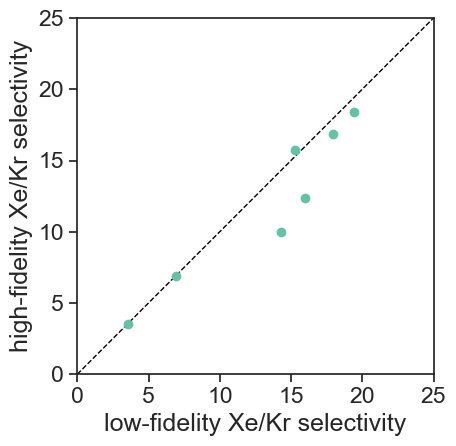

In [32]:
# build selectivity array for plotting, 
y_los = [y[0][c].item() for c in ids_cofs_hi_and_lo_fid]
y_his = [y[1][c].item() for c in ids_cofs_hi_and_lo_fid]

fig = plt.figure()
plt.plot([0, 25], [0, 25], linestyle="--", color="k", linewidth=1)
plt.scatter(y_los, y_his, zorder=10)
ax = plt.gca()
plt.xlim(0, 25)
plt.ylim(0, 25)
ax.set_aspect("equal", "box")
plt.xlabel("low-fidelity Xe/Kr selectivity")
plt.ylabel("high-fidelity Xe/Kr selectivity")
plt.tight_layout()
if save_figures:
    plt.savefig("../figs/lo_vs_hi_fid_selectivity.pdf", format='pdf')
plt.show()

In [33]:
# get COF ids not in acquired set with high-fidelity sims. these are test COFs for high-fidelity standpoint.
test_cof_ids = [cof_id for cof_id in range(nb_COFs) if not (cof_id in hi_fid_cofs)]
len(test_cof_ids)

601

In [34]:
cof_id_with_max_hi_fid_selectivity in test_cof_ids # the COF with the highest selectivity should be in here. cuz we didn't acquire it yet.

True

In [35]:
id_in_test_cofs_of_opt_cof = np.where([c == cof_id_with_max_hi_fid_selectivity for c in test_cof_ids])[0].item()
id_in_test_cofs_of_opt_cof

371

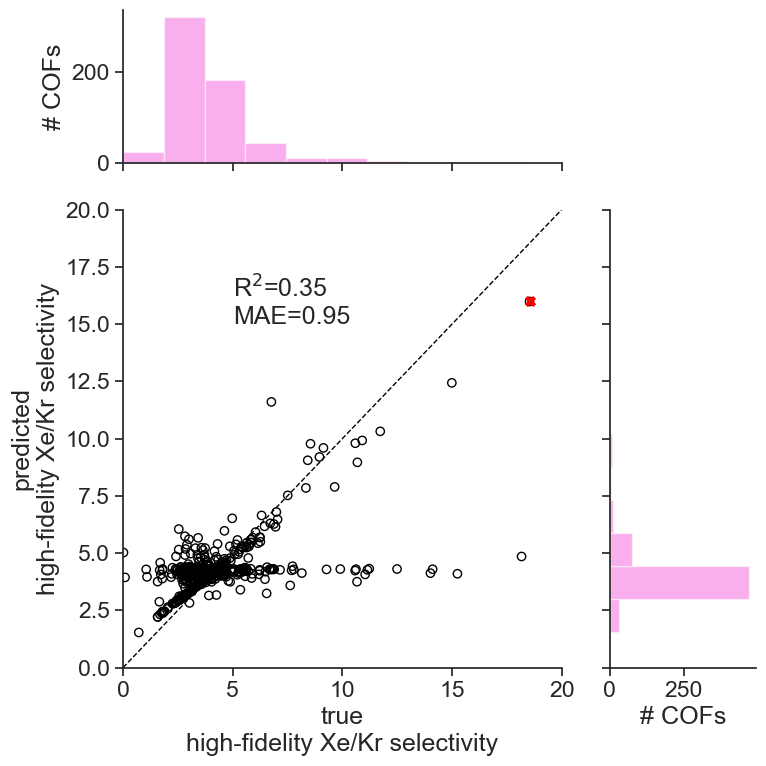

In [36]:
# train surrogate model for test data, on acquired set up till top COF was found.
X_train = build_X_train(acquired_set[:n_iter_top_cof_found])
y_train = build_y_train(acquired_set[:n_iter_top_cof_found])

X_test = X[test_cof_ids, :]

model = train_surrogate_model(X_train, y_train)

# get model predictions on test COFs, for high-fidelity.
y_pred, sigma = mu_sigma(model, X_test, discrete_fidelities[-1])

# plot true vs predicted
y_true = [y[1][c].item() for c in test_cof_ids]

r2 = r2_score(y_true, y_pred)
abserr = mean_absolute_error(y_true, y_pred)

###
#  parity plot
###
gridspec_kw={'width_ratios': [6, 2], 'height_ratios': [2, 6]} # set ratios
fig, ax = plt.subplots(nrows=2, ncols=2, gridspec_kw=gridspec_kw, figsize=(8, 8))
# fig = plt.figure()
ax[0, 1].axis("off")
ax[1, 0].plot([0, 20], [0, 20], linestyle="--", color="k", linewidth=1)
# ax = plt.gca()
ax[1, 0].set_xlim(0, 20)
ax[1, 0].set_ylim(0, 20)

#ax[1, 0].set_aspect("equal", "box")

ax[1, 0].text(5, 15, "R$^2$=%.2f\nMAE=%.2f" % (r2, abserr))
ax[1, 0].scatter(y_true, y_pred, fc='none', ec="k")
ax[1, 0].set_xlabel("true\nhigh-fidelity Xe/Kr selectivity")
ax[1, 0].set_ylabel("predicted\nhigh-fidelity Xe/Kr selectivity")
# plot acquired COF
ax[1, 0].scatter(y_true[id_in_test_cofs_of_opt_cof], y_pred[id_in_test_cofs_of_opt_cof], marker="x", color="red")


###
#  histogram of selectivities
###
hist_color = sns.color_palette("husl", 8)[7]
ax[0, 0].hist(y_true, color=hist_color, alpha=0.5) # 
ax[0, 0].sharex(ax[1, 0])
ax[0, 0].set_ylabel('# COFs')
plt.setp(ax[0, 0].get_xticklabels(), visible=False) # remove yticklabels

hist_color = sns.color_palette("husl", 8)[7]
ax[1, 1].hist(y_pred, color=hist_color, alpha=0.5, orientation="horizontal") # 
ax[1, 1].sharey(ax[1, 0])
ax[1, 1].set_xlabel('# COFs')
plt.setp(ax[1, 1].get_yticklabels(), visible=False) # remove yticklabels

sns.despine()
plt.tight_layout()
if save_figures:
    plt.savefig("../figs/surrogate_parity_with_hist.pdf", format="pdf")

plt.show()

for kicks, compare to RF.

In [37]:
rf = RandomForestRegressor()
rf.fit(X_train[:, :14], y_train)
rf.score(X_test, y_true)

/var/folders/b3/p558slm10qj7tzmkx22rhyc80000gn/T/ipykernel_35154/4244545905.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train[:, :14], y_train)


0.06935117296554882

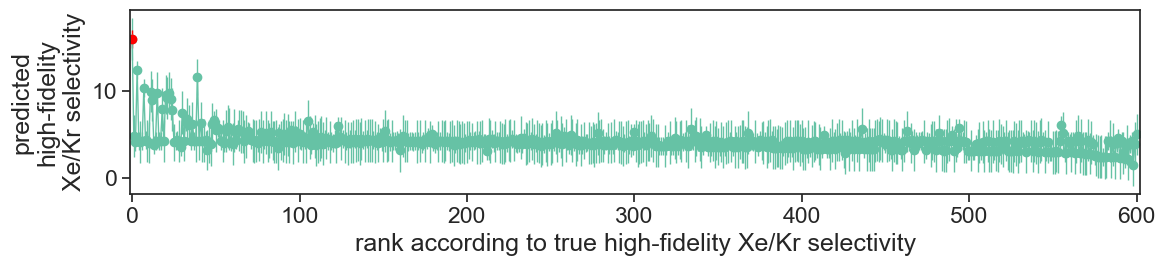

In [38]:
ids_sorted = np.argsort(y_true)[::-1]

plt.figure(figsize=(12, 3))
plt.errorbar(range(len(y_true)), y_pred[ids_sorted], yerr=sigma, linewidth=1, marker="o")
plt.errorbar(0, y_pred[id_in_test_cofs_of_opt_cof], yerr=sigma[id_in_test_cofs_of_opt_cof], linewidth=1, marker="o", color="red")
plt.xlabel("rank according to true high-fidelity Xe/Kr selectivity")
plt.ylabel("predicted\nhigh-fidelity\nXe/Kr selectivity")
plt.xlim(-1, len(test_cof_ids) +1)
plt.tight_layout()
if save_figures:
    plt.savefig("../figs/surrogate_predictions.pdf", format="pdf")

plt.show()

In [39]:
cof_id_with_max_hi_fid_selectivity

375

In [40]:
np.where([cof_id == cof_id_with_max_hi_fid_selectivity for cof_id in test_cof_ids])

(array([371]),)

# Run MFBO under different initializations

In [41]:
def save_run_results(acquired_set, run, ablation_study_flag):
    # compute attributes of acquired set
    y_acquired    = build_y_train(acquired_set)
    y_maxes_acq   = get_y_maxes_hf_acquired(acquired_set.detach().numpy())
    fid_fraction  = calc_fidelity_fraction(acquired_set.detach().numpy(), discrete_fidelities[1])
    cost_acquired = build_cost(acquired_set)
    acc_cost      = accumulated_cost(acquired_set)
    
    # when did MFBO recover top COF?
    cof_id_with_max_selectivity = np.argmax(y[1])
    BO_iter_top_cof_acquired = float("inf") # dummy 
    for i, (f_id, cof_id) in enumerate(acquired_set):
        if cof_id.to(dtype=int) == cof_id_with_max_selectivity and get_f_ids(f_id) == 1:
            BO_iter_top_cof_acquired = i
            break
        elif i == len(acquired_set) - 1:
            print("oh no, top COF not acquired!")
    
    mfbo_res = dict({
        'acquired_set': acquired_set.detach().numpy(),
         'y_acquired': y_acquired.detach().numpy(),
         'y_max_acquired': y_maxes_acq,
         'fidelity_fraction': fid_fraction,
         'cost_acquired': cost_acquired.flatten().detach().numpy(),
         'accumulated_cost': acc_cost / 60,
         'nb_COFs_initialization': nb_COFs_initialization,
         'BO_iter_top_cof_acquired': BO_iter_top_cof_acquired,
         'elapsed_time (min)': 0.0,
         'post_preprint': True
        })
    
    pickle_filename = '../search_results/mfbo_results/mfbo_results_run_{}'.format(run)
    if ablation_study_flag:
        pickle_filename += "_ablation"
    pickle_filename += ".pkl"
    with open(pickle_filename, 'wb') as file:
        pickle.dump(mfbo_res, file)

In [42]:
###
#  run search
###
for j in range(nb_runs):
    initializing_COFs = init_cof_ids[j]
    if ablation_study_flag:
        # each time, randomly shuffle features within a column
        for k in range(X.size()[1]):
            row_ids = torch.randperm(X.size()[0])
            X[:, k] = X[row_ids, k]

    # check the length of each initializing set
    assert len(initializing_COFs) == nb_COFs_initialization
    print("run #: {}".format(j))

    ###
    #  run BO search
    ###
    acquired_set = run_Bayesian_optimization(nb_iterations, initializing_COFs)
    save_run_results(acquired_set, j, ablation_study_flag)

run #: 0
BO iteration:  6
BO iteration:  7
BO iteration:  8
BO iteration:  9
BO iteration:  10
BO iteration:  11
BO iteration:  12
BO iteration:  13
BO iteration:  14
BO iteration:  15
BO iteration:  16
BO iteration:  17
BO iteration:  18
BO iteration:  19
BO iteration:  20
BO iteration:  21
BO iteration:  22
BO iteration:  23
BO iteration:  24
BO iteration:  25
BO iteration:  26
BO iteration:  27
BO iteration:  28
BO iteration:  29
BO iteration:  30
BO iteration:  31
BO iteration:  32
BO iteration:  33
BO iteration:  34
BO iteration:  35
BO iteration:  36
BO iteration:  37
BO iteration:  38
BO iteration:  39
BO iteration:  40
BO iteration:  41
BO iteration:  42
BO iteration:  43
BO iteration:  44
BO iteration:  45
BO iteration:  46
BO iteration:  47
BO iteration:  48
BO iteration:  49
BO iteration:  50
BO iteration:  51
BO iteration:  52
BO iteration:  53
BO iteration:  54
BO iteration:  55
BO iteration:  56
BO iteration:  57
BO iteration:  58
BO iteration:  59
BO iteration:  60
BO it

/Users/cokes/anaconda3/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/Users/cokes/anaconda3/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-07 to the diagonal
  warnings.warn(
/Users/cokes/anaconda3/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/cokes/anaconda3/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/cokes/anaconda3/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/cokes/anaconda3/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p

BO iteration:  213
BO iteration:  214
BO iteration:  215
BO iteration:  216
BO iteration:  217
BO iteration:  218
BO iteration:  219
BO iteration:  220
BO iteration:  221
BO iteration:  222
BO iteration:  223
BO iteration:  224
BO iteration:  225
BO iteration:  226
BO iteration:  227
BO iteration:  228
BO iteration:  229
BO iteration:  230
BO iteration:  231
BO iteration:  232
BO iteration:  233
BO iteration:  234
BO iteration:  235
BO iteration:  236
BO iteration:  237
BO iteration:  238
BO iteration:  239
BO iteration:  240
BO iteration:  241
BO iteration:  242
BO iteration:  243
BO iteration:  244
BO iteration:  245
BO iteration:  246
BO iteration:  247
BO iteration:  248
BO iteration:  249
BO iteration:  250
BO iteration:  251
BO iteration:  252
BO iteration:  253
BO iteration:  254
BO iteration:  255
BO iteration:  256
BO iteration:  257
BO iteration:  258
BO iteration:  259
BO iteration:  260
BO iteration:  261
BO iteration:  262
BO iteration:  263
BO iteration:  264
BO iteration

/Users/cokes/anaconda3/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/Users/cokes/anaconda3/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-07 to the diagonal
  warnings.warn(
/Users/cokes/anaconda3/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/cokes/anaconda3/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/cokes/anaconda3/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/cokes/anaconda3/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p

BO iteration:  505
BO iteration:  506
BO iteration:  507
BO iteration:  508
BO iteration:  509
BO iteration:  510
BO iteration:  511
BO iteration:  512
BO iteration:  513
BO iteration:  514
BO iteration:  515
BO iteration:  516
BO iteration:  517
BO iteration:  518
BO iteration:  519
BO iteration:  520
BO iteration:  521
BO iteration:  522
BO iteration:  523
BO iteration:  524
BO iteration:  525
BO iteration:  526
BO iteration:  527
BO iteration:  528
BO iteration:  529
BO iteration:  530
BO iteration:  531
BO iteration:  532
BO iteration:  533
BO iteration:  534
BO iteration:  535
BO iteration:  536
BO iteration:  537
BO iteration:  538
BO iteration:  539
BO iteration:  540
BO iteration:  541
BO iteration:  542
BO iteration:  543
BO iteration:  544
BO iteration:  545
BO iteration:  546
BO iteration:  547
BO iteration:  548
BO iteration:  549
BO iteration:  550
BO iteration:  551
BO iteration:  552
BO iteration:  553
BO iteration:  554
BO iteration:  555
BO iteration:  556
BO iteration